# CS5489 - Machine Learning
# Lecture 3b - Support Vector Machines
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Discriminative classifiers
2. Logistic regression
3. **Support vector machines**

# Support vector machines
- With logistic regression we used a maximum-likelihood framework to learn the separating hyperplane.
- Let's consider a purely geometric approach...

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
import warnings
#warnings.filterwarnings("ignore")

# Linearly-Separable Data
- For now, assume the training data is _linearly separable_
  - the two classes in the training data can be separated by a line (hyperplane)

In [2]:
# generate random data
X,Y = datasets.make_blobs(n_samples=50, 
         centers=2, cluster_std=2, n_features=2, 
         center_box=[-5,5], random_state=4487)
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

lsdatafig = plt.figure()   
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
axbox = [-10,10,-10,10]
plt.axis('equal'); plt.axis(axbox); plt.grid(True);
plt.close()

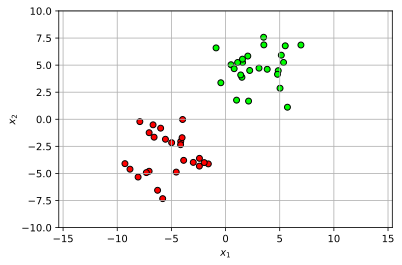

In [3]:
lsdatafig

# Which is the best separating line?
- there are many possible solutions...

In [4]:
def drawplane(w, b=None, c=None, wlabel=None, poscol=None, negcol=None, lw=2, ls='k-', label=None):
    # w^Tx + b = 0
    # w0 x0 + w1 x1 + b = 0
    # x1 = -w0/w1 x0 - b / w1

    # OR
    # w^T (x-c) = 0 = w^Tx - w^Tc  --> b = -w^Tc
    if c is not None:
        b = -sum(w*c)
    
    # the line
    if (abs(w[0])>abs(w[1])):   # vertical line
        x0 = array([-30,30])
        x1 = -w[0]/w[1] * x0 - b / w[1]
    else:                       # horizontal line
        x1 = array([-30,30])
        x0 = -w[1]/w[0] * x1 - b / w[0]
    
    # fill positive half-space or neg space
    #if (poscol):
    #    polyx = [x0[0], x0[-1], x0[-1], x0[0]]
    #    polyy = [x1[0], x1[-1], x1[0], x1[0]]
    #    plt.fill(polyx, polyy, poscol, alpha=0.2)
    # 
    #if (negcol):
    #    polyx = [x0[0], x0[-1], x0[0], x0[0]]
    #    polyy = [x1[0], x1[-1], x1[-1], x1[0]]
    #    plt.fill(polyx, polyy, negcol, alpha=0.2)

    if (poscol) or (negcol):
        polyx = [x0[0], x0[-1], x0[-1], x0[0]]
        polyy = [x1[0], x1[-1], x1[0], x1[0]]
        f = sum(w*[polyx[2], polyy[2]])+b
        if (f>0) and (poscol):
            plt.fill(polyx, polyy, poscol, alpha=0.2)
        if (f<0) and (negcol):
            plt.fill(polyx, polyy, negcol, alpha=0.2)
    
        polyx = [x0[0], x0[-1], x0[0], x0[0]]
        polyy = [x1[0], x1[-1], x1[-1], x1[0]]
        f = sum(w*[polyx[2], polyy[2]])+b
        if (f>0) and (poscol):
            plt.fill(polyx, polyy, poscol, alpha=0.2)
        if (f<0) and (negcol):
            plt.fill(polyx, polyy, negcol, alpha=0.2)

    # plot line
    plt.plot(x0, x1, ls, lw=lw, label=label)

    # the w
    if (wlabel):
        xp = array([0, -b/w[1]])
        xpw = xp+w
        plt.arrow(xp[0], xp[1], w[0], w[1], width=0.01)
        plt.text(xpw[0]-0.5, xpw[1], wlabel)

In [5]:
seplinefig = plt.figure()
ws = array([[1,0.1], [0.1,1], [1,1.5], [1.5,1]])
bs = array([0.9, -1, 2, 2.5])

for i in range(len(bs)):
    plt.subplot(2,2,i+1)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
    drawplane(ws[i,:], bs[i], poscol='g', negcol='r')
    plt.axis('equal'); plt.axis(axbox); plt.grid(True)
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])    
    
plt.close()

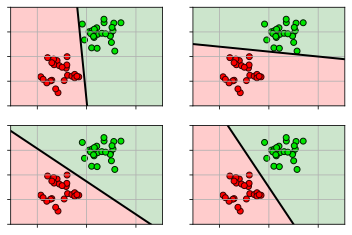

In [6]:
seplinefig

# Maximum margin
- Define the space between the separating line and the closest point as the _margin_.
  - think of this space as the "amount of wiggle room" for accommodating errors in estimating $\mathbf{w}$. 

In [7]:
def drawmargin(w,b,xmarg=None, label=None):
    wnorm = w / sqrt(sum(w**2))
    if xmarg is None:
        # calculate a point on the margin
        dm = 1 / sqrt(sum(w**2))
        xpt  = array([1,-w[0]/w[1]-b/w[1]])
        # then find the margin (assuming learned with SVM)
        xmarg = xpt + dm*wnorm
        xmarg2 = xpt - dm*wnorm
    else:
        # find the distance to the margin
        dm = (sum(w*xmarg)+b) / sqrt(sum(w**2))
        # move to the other side of the decision plane
        xmarg2 = xmarg - 2*dm*wnorm

    drawplane(w, c=xmarg, ls='k--', lw=1, label=label)
    drawplane(w, c=xmarg2, ls='k--', lw=1)

In [8]:
w = array([1.5,1])
b = 2.5

# calculate distance to margin
d = abs(dot(X,w.T) + b)
mmi = argmin(d)
x0 = X[mmi,:]

margfig = plt.figure()
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
drawplane(w, b, poscol='g', negcol='r', label='boundary')
plt.plot(x0[0], x0[1], 'ko', fillstyle='none', markeredgewidth=2)
drawmargin(w,b,x0, label='margin')
plt.axis('equal'); plt.axis(axbox); plt.grid(True)    
leg = plt.legend(loc='lower right' ,fontsize=10)
leg.get_frame().set_facecolor('white') 
plt.annotate(text='margin point', xy=x0, xytext=(-12.5,2.0), 
             arrowprops=dict(facecolor='black', width=2, shrink=0.1, headwidth=6))
plt.close()

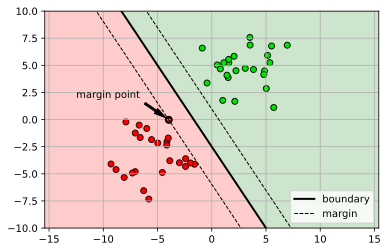

In [9]:
margfig

- **Idea:** the best separating line is the one that _maximizes the margin_.
  - i.e., puts the most distance between the closest points and the decision boundary.

In [10]:
margfigs = plt.figure()
for i in range(len(bs)):
    w = ws[i,:]
    b = bs[i]
    d = abs(dot(X,w.T) + b)
    mmi = argmin(d)
    x0 = X[mmi,:]

    plt.subplot(2,2,i+1)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
    drawplane(w, b, poscol='g', negcol='r')
    drawmargin(w, b, x0)
    plt.axis('equal'); plt.axis(axbox); plt.grid(True)
    
plt.close()

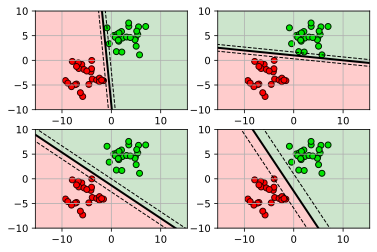

In [11]:
margfigs

- _the solution..._
  - by symmetry, there should be at least one margin point on each side of the boundary
  - the points on the margins are called the **support vectors**
    - the points support (define) the margin

In [12]:
# fit SVM (kernel is the type of decision surface...more in the next lecture)
clf = svm.SVC(kernel='linear', C=inf)
clf.fit(X, Y)

def plot_svm(clf, axbox, mycmap, showleg=True):
    # get line parameters
    w = clf.coef_[0]
    b = clf.intercept_[0]

    drawplane(w, b, poscol='g', negcol='r', label='boundary')
    drawmargin(w, b, label='margin')
    plt.plot(clf.support_vectors_[:,0], clf.support_vectors_[:,1],
         'ko',fillstyle='none', markeredgewidth=2, label='support vectors')
    plt.grid(True); plt.axis('equal'); plt.axis(axbox);
    if showleg:
        leg = plt.legend(loc='lower right', fontsize=10)
        leg.get_frame().set_facecolor('white') 
        
    
maxmfig = plt.figure()
plot_svm(clf, axbox, mycmap)
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
plt.close()




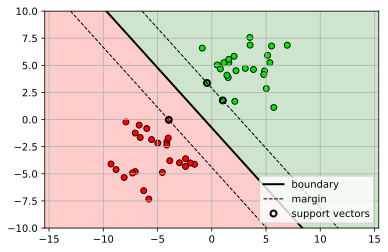

In [13]:
maxmfig

# Why is maximizing the margin good?
- the true $\mathbf{w}$ is uncertain
  - maximizing the margin allows the most uncertainty (wiggle room) for $\mathbf{w}$, while keeping all the points correctly classified.

In [14]:
maxmfigw = plt.figure()
plot_svm(clf, axbox, mycmap, showleg=False)
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')

w = clf.coef_[0]
b = clf.intercept_[0]
for i in range(10):
    w2 = w + 0.05*random.standard_normal(w.shape)
    b2 = b + 0.2*random.standard_normal(b.shape)
    drawplane(w2, b2, lw=0.5, ls='b-')
plt.close()

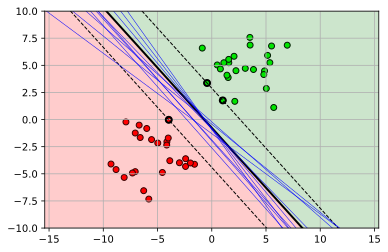

In [15]:
maxmfigw

- the data points are uncertain
  - maximizing the margin allows the most wiggle of the points, while keeping all the points correctly classified.

In [16]:
maxmfigp = plt.figure()
plot_svm(clf, axbox, mycmap)
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
plt.scatter(X[:,0], X[:,1], s=500, alpha=0.5, color='gray')
plt.close()

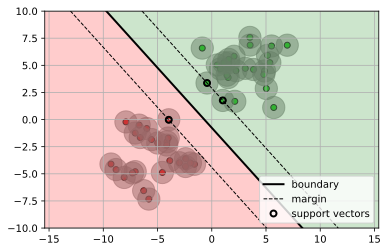

In [17]:
maxmfigp

# SVM Training
- Given a training set $\{\mathbf{x}_i,y_i\}_{i=1}^N$.
- First define the margin distance:
  - Distance from a point $\mathbf{x}_i$ to hyperplane $\mathbf{w}$: 
  $$d_i = \frac{|f(\mathbf{x}_i)|}{||\mathbf{w}||}$$
  - Margin distance is the minimum distance among all points: 
  $$\gamma = \min_i \frac{|f(\mathbf{x}_i)|}{||\mathbf{w}||}$$

In [18]:
def draw_dist(X, w, b, justmargin=False):
    wu = sqrt(w@w)
    d = (X@w + b) / wu
    Xo = w*d[:,newaxis] / wu
    Xp = X-Xo
    #plt.scatter(Xp[:,0], Xp[:,1])
    if not justmargin:
        for xp,x in zip(Xp,X):
            plt.plot([xp[0], x[0]], [xp[1], x[1]], ':b', lw=0.5)
    mm = amin(abs(d))
    for i,myd in enumerate(abs(d)):
        if abs(myd-mm) <= .001*mm:
            plt.plot([Xp[i,0], X[i,0]], [Xp[i,1],X[i,1]], 'b-', label="margin distance $\gamma$")
    #mmd = plt.plot([Xp[mmi,0], X[mmi,0]], [Xp[mmi,1],X[mmi,1]], 'b-', label="margin distance $\gamma$")
    

In [19]:
dfig = plt.figure()
w = ws[3,:]
b = bs[3]
d = abs(dot(X,w.T) + b)
mmi = argmin(d)
x0 = X[mmi,:]

plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
drawplane(w, b, poscol='g', negcol='r')
drawmargin(w, b, x0)
draw_dist(X, w, b)
plt.grid(True)
plt.axis('equal')
plt.axis(axbox);
plt.legend()
    
plt.close()

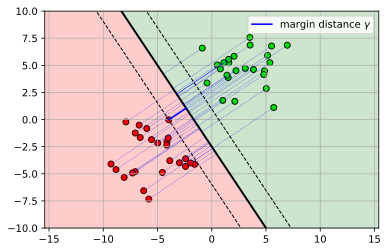

In [20]:
dfig

- The hyperplane $\mathbf{w}$ appears in both numerator and denominator! 
  - $\gamma =  \min_i \frac{|f(\mathbf{x}_i)|}{||\mathbf{w}||}= \min_i \frac{|\mathbf{w}^T\mathbf{x}_i+b|}{||\mathbf{w}||}$
- Changing the length of $\mathbf{w}$ won't affect the margin distance.
  - $\hat{\mathbf{w}} = a\mathbf{w}$, $\hat{b} = ab$
  - $ \frac{|\hat{\mathbf{w}}^T\mathbf{x}_i+\hat{b}|}{||\hat{\mathbf{w}}||} = \frac{|a\mathbf{w}^T\mathbf{x}_i+ab|}{||a\mathbf{w}||} = \frac{|\mathbf{w}^T\mathbf{x}_i+b|}{||\mathbf{w}||}$
- Margin distance is determined by the direction of $\mathbf{w}$, not the length.

# Normalization
- Since the length of $\mathbf{w}$ doesn't matter, we can assume a normalization for $\mathbf{w}$.
- Two possibilities:
  1. set denominator to 1: $||\mathbf{w}|| = 1$
    - $||\mathbf{w}||$ is a unit-norm vector
  2. set numerator to 1: $\min_i |f(\mathbf{x}_i)|=1$
    - the point $\mathbf{x}_i$ on the margin has $f(\mathbf{x}_i)=1$.
- Which is better?

# SVM Optimization Problem
- Choose the 2nd option.
  - constraint: $\min_i |f(\mathbf{x}_i)|=1$
  - margin: $\gamma = \frac{1}{||\mathbf{w}||}$
- Maximize the margin:
  $$ (\hat{\mathbf{w}},b) = \mathop{\mathrm{argmax}}_{\mathbf{w},b} \frac{1}{||\mathbf{w}||} \quad \text{s.t.}\   \min_i |f(\mathbf{x}_i)|=1 $$
- Invert the objective to turn into a minimization problem
  $$ (\hat{\mathbf{w}},b) = \mathop{\mathrm{argmin}}_{\mathbf{w},b} \frac{1}{2}||\mathbf{w}||^2 \quad \text{s.t.}\   \min_i |f(\mathbf{x}_i)|=1 $$

- Closer look: 
  - original constraint: $\min_i |f(\mathbf{x}_i)|=1$
    - the minimum over all $i$ is 1.
  - equivalent constraint: $|f(\mathbf{x}_i)| \geq 1, \forall i$
    - since we are minimizing $||\mathbf{w}||$, $\mathbf{w}$ will shrink at the optimum so that at least one  $\mathbf{x}_i$ will have $|f(\mathbf{x}_i)| = |\mathbf{w}^T\mathbf{x}_i+b|= 1$,


- Note: if the points are correctly classified...
  - for points in class $y_i=1$, then $f(\mathbf{x}_i) > 0$ .
  - for points in class $y_i=-1$, then $f(\mathbf{x}_i) < 0$.
- Thus, the constraint: $|f(\mathbf{x}_i)| \geq 1, \forall i$
  - can be rewritten: $y_i f(\mathbf{x}_i) \geq 1, \forall i$

# SVM Training Objective
- given a training set $\{\mathbf{x}_i,y_i\}_{i=1}^N$, optimize:
  $$ \begin{aligned}\mathop{\mathrm{argmin}}_{\mathbf{w},b} &\frac{1}{2} \mathbf{w}^T\mathbf{w}\\\mathrm{s.t.}~&y_i f(\mathbf{x}_i)\geq 1,\quad \forall i\end{aligned}$$
  - the objective minimizes the inverse of the margin distance, i.e., maximizes the margin.
  - the inequality constraints ensure that all points are either on or outside of the margin.
    - a point on the margin has $f(\mathbf{x}_i)=1$. 

# SVM Prediction
- given a new data point $\mathbf{x}_*$, use sign of linear function to predict class
    - $y_* = \mathop{\mathrm{sign}} f(\mathbf{x}_*) = \mathop{\mathrm{sign}}(\mathbf{w}^T \mathbf{x}_* + b)$

# Example
- Regions defined by $f(\mathbf{x})$:
  - $f(\mathbf{x})=0$ -- decision boundary
  - $f(\mathbf{x})=\pm1$ -- positive and negative margins
  - $f(\mathbf{x})>1$ -- points correctly classified as class 1
  - $f(\mathbf{x})<-1$ -- points correctly classified as class -1


In [21]:
# fit SVM (kernel is the type of decision surface...more in the next lecture)
clf = svm.SVC(kernel='linear', C=inf)
clf.fit(X, Y)

egsvmfig = plt.figure()
plot_svm(clf, axbox, mycmap)
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
draw_dist(X, clf.coef_[0], clf.intercept_[0], justmargin=True)
plt.text(-9.5,7.5, '$f(\mathbf{x})=0$', fontsize=9, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
plt.text(-5,7.5, '$f(\mathbf{x})=1$', fontsize=9, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
plt.text(-12,5, '$f(\mathbf{x})=-1$', fontsize=9, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
plt.text(7,5, '$f(\mathbf{x})>1$', fontsize=9, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
plt.text(-12,-2.5, '$f(\mathbf{x})<-1$', fontsize=9, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
plt.annotate(text='$\gamma = 1/||\mathbf{w}||$', xy=(0,1), xytext=(2.5,-2.0), 
             backgroundcolor='white', 
             arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=6))
plt.close()

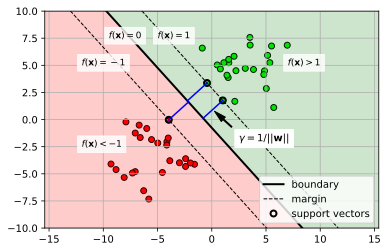

In [22]:
egsvmfig

# What about non-separable data?
- use the same linear classifier
  - allow some training samples to **violate** the margin
    - i.e., are inside the margin (or even mis-classified)

- Define "slack" variable $\xi_i \geq 0$
  - $\xi_i=0$ means sample is outside of margin area (no slack)
  - $\xi_i>0$ means sample is inside of margin area (slack)

In [23]:
slackfig = plt.figure(figsize=(5,5))
plot_svm(clf, axbox, mycmap, showleg=False)
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')

xv = array([0.5, -2])
xm = xv-clf.coef_.ravel()*5.2

plt.scatter([xv[0]], [xv[1]], c=[1], cmap=mycmap, edgecolors='k')
# slack point
plt.annotate(text='violates margin', xy=xv, xytext=(4.0,-2.0), 
             backgroundcolor='white', 
             arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=6))

plt.annotate(text="", xy=xv, xytext=xm, 
            arrowprops=dict(arrowstyle="<->"))
plt.text(-0.2, -3.5, "$\\xi_i>0$", fontsize=12)
plt.text(-5, -7, "$\\xi_i=0$", fontsize=14)
plt.close()

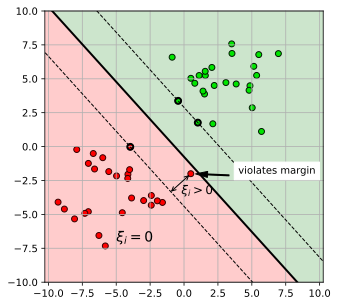

In [24]:
slackfig

- constraint now includes slack variable 
  - $y_i f(\mathbf{x}_i)\geq 1-\xi_i,\forall i$
- Two possibilities:
  - $\xi_i=0$, then sample $\mathbf{x}_i$ has normal margin constraint: $y_i f(\mathbf{x}_i)\geq 1$
  - $\xi_i>0$, then sample $\mathbf{x}_i$ is inside margin: $y_i f(\mathbf{x}_i) = 1-\xi_i$
    - Note that: $y_i f(\mathbf{x}_i) < 1$, inside margin.

# Soft-SVM optimization problem
- Penalize each training sample that violates the margin by summing over $\xi_i$.
  - penalty controlled by hyperparameter $C$.
    - smaller value means allow more violations (less penalty)
    - larger value means don't allow violations (more penalty)

$$\begin{aligned}\mathop{\mathrm{argmin}}_{\mathbf{w},b} &\frac{1}{2} \mathbf{w}^T\mathbf{w} + C\sum_{i=1}^N \xi_i \\\mathrm{s.t.}~&y_if(\mathbf{x}_i)\geq 1-\xi_i,\quad \forall i\\&\xi_i\geq 0\end{aligned}$$

In [25]:
# generate non-separable random data
X,Y = datasets.make_blobs(n_samples=50, 
         centers=2, cluster_std=3.5, n_features=2, 
         center_box=[-5,5], random_state=4487)

Cs = [0.01, 0.1, 1, 10]
Cmargfigs = plt.figure()

for i in range(len(Cs)):
    # fit SVM
    clf = svm.SVC(kernel='linear', C=Cs[i])
    clf.fit(X, Y)

    plt.subplot(2,2,i+1)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
    plot_svm(clf, axbox, mycmap, showleg=False)
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title("C="+str(Cs[i]))
    
plt.close()

- Example with different $C$.

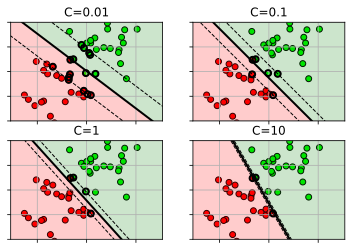

In [26]:
Cmargfigs

# Loss function
- After some massaging, the objective function is:
$$ \mathop{\mathrm{argmin}}_{\mathbf{w},b} \frac{1}{C} \mathbf{w}^T\mathbf{w} + \sum_{i=1}^N \max(0, 1-y_i f(\mathbf{x}_i))$$
  - hinge loss function: $L(z_i) = \max(0,1-z_i)$
    - Note: $\max(a,b)$ returns whichever value ($a$ or $b$) is largest.

In [27]:
z = linspace(-6,6,100)
logloss = log(1+exp(-z))
hingeloss = maximum(0, 1-z)
lossfig = plt.figure()
plt.plot(z,hingeloss, 'b-')

plt.plot([0,0], [0,9], 'k--')
plt.text(0,8.5, "incorrectly classified $\\Leftarrow$ ", ha='right', weight='bold')
plt.text(0,8.5, " $\Rightarrow$ correctly classified", ha='left', weight='bold')

plt.annotate(text="large loss for badly\nmisclassified samples", 
             xy=(-4,5), xytext=(-4.5,6.2),backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.annotate(text="non-zero loss\nfor samples\nnear margin", 
             xy=(0.5,0.5), xytext=(-0.5,3.2), backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.annotate(text="zero loss for\nsamples on correct\nside of margin", 
             xy=(3,0.0), xytext=(2,1.1), backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.xlabel('$z_i$');
plt.ylabel('loss')
plt.title('hinge loss')
plt.xlim(-6,6)
plt.close()

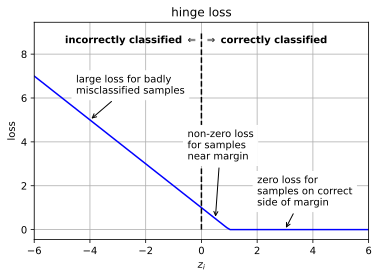

In [28]:
lossfig

# Example: Iris Data

In [29]:
# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris2.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label (versicolor=1, virginica=2)

print(X.shape)

(100, 2)


In [30]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.5, test_size=0.5, random_state=4487)

print(trainX.shape)
print(testX.shape)

(50, 2)
(50, 2)


In [31]:
# fit the SVM using all the data and the best C   
clf = svm.SVC(kernel='linear', C=2)
clf.fit(trainX, trainY)

# get line parameters
w = clf.coef_[0]
b = clf.intercept_[0]
print(w)
print(b)

[2.87200943 0.10399865]
-13.95923965217775


In [32]:
# indices of data points that are support vectors (on or inside the margin)
clf.support_

array([ 0,  7, 12, 31, 36, 41, 13, 20, 22, 25, 33, 46], dtype=int32)

In [33]:
axbox = [2.5, 7, 1.5, 4]
svmfig = plt.figure()
plot_svm(clf, axbox, mycmap)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.title('class boundary with training data');
plt.close()

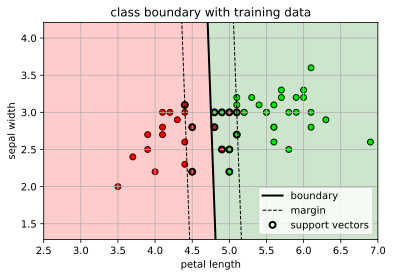

In [34]:
svmfig

- SVM doesn't have it's own dedicated cross-validation function
- Use the `GridSearchCV` to run cross-validation for a list of parameters
  - calculate average accuracy for each parameter
  - select parameter with average highest accuracy, retrain model with all data
  - Speed up: each parameter can be trained/tested separately, specify number of parallel jobs using `n_jobs`

In [35]:
# setup the list of parameters to try
paramgrid = {'C': logspace(-3,3,13)}
print(paramgrid)

# setup the cross-validation object
# pass the SVM object, parameter grid, and number of CV folds
# set number of parallel jobs to -1 (use all cores)
svmcv = model_selection.GridSearchCV(svm.SVC(kernel='linear'), paramgrid, cv=5,
                                     n_jobs=-1, verbose=True)

# run cross-validation (train for each split)
svmcv.fit(trainX, trainY);

{'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])}
Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    1.8s finished


In [36]:
# show the test error for each parameter set
for m,p in zip(svmcv.cv_results_['mean_test_score'], svmcv.cv_results_['params']):
    print("mean={:.4f} {}".format(m,p))

mean=0.6200 {'C': 0.001}
mean=0.6200 {'C': 0.0031622776601683794}
mean=0.6200 {'C': 0.01}
mean=0.6600 {'C': 0.03162277660168379}
mean=0.9400 {'C': 0.1}
mean=0.9600 {'C': 0.31622776601683794}
mean=0.9400 {'C': 1.0}
mean=0.9400 {'C': 3.1622776601683795}
mean=0.9400 {'C': 10.0}
mean=0.9200 {'C': 31.622776601683793}
mean=0.9000 {'C': 100.0}
mean=0.9000 {'C': 316.22776601683796}
mean=0.9000 {'C': 1000.0}


{'C': 0.31622776601683794}
0.96
SVC(C=0.31622776601683794, kernel='linear')


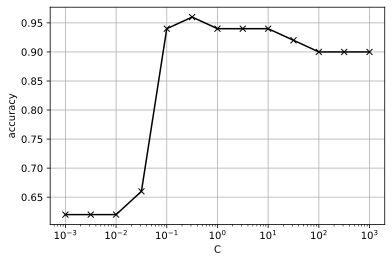

In [37]:
# make a plot
allC      = [p['C'] for p in svmcv.cv_results_['params']]
allscores = svmcv.cv_results_['mean_test_score']
    
plt.figure()
plt.semilogx(allC, allscores, 'kx-')
plt.xlabel('C'); plt.ylabel('accuracy')
plt.grid(True)

# view best results and best retrained estimator
print(svmcv.best_params_)
print(svmcv.best_score_)
print(svmcv.best_estimator_)

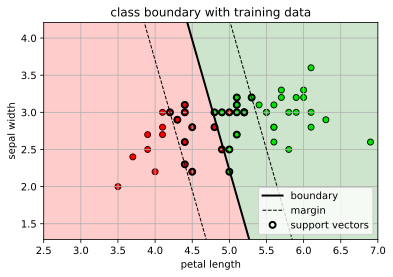

In [38]:
plt.figure()
plot_svm(svmcv.best_estimator_, axbox, mycmap)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.title('class boundary with training data');

In [39]:
# Directly use svmcv to make predictions
predY = svmcv.predict(testX)

acc = metrics.accuracy_score(testY, predY)
print("test accuracy = " + str(acc))

test accuracy = 0.88


In [40]:
# Plot test data
tsvmfig = plt.figure()
plot_svm(svmcv.best_estimator_, axbox, mycmap)
plt.scatter(testX[:,0], testX[:,1], c=testY, cmap=mycmap, marker='s', edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.title('class boundary with testing data');
plt.close()

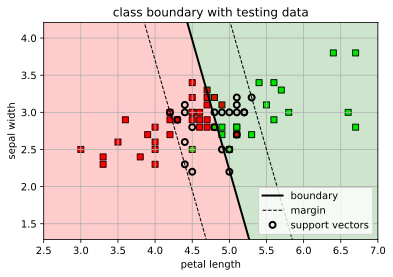

In [41]:
tsvmfig

# Multi-class SVM
- In sklearn, `svm.SVC` implements  "1-vs-1" multi-class classification.
  - Train binary classifiers on all pairs of classes.
    - 3-class Example: 1 vs 2, 1 vs 3, 2 vs 3
  - To label a sample, pick the class with the most votes among the binary classifiers.
- Problem:
  - 1v1 classification is very slow when there are a large number of classes.
    - if there are $C$ classes, need to train $C(C-1)/2$ binary classifiers!

# 1-vs-all SVM
- Use the `multiclass.OneVsRestClassifier` to build a 1-vs-all classifier from any binary classifier.
  - pass it the binary classifier as the base classifier.  
- For `GridSearchCV`, the binary SVM is embedded inside the 1-vs-all wrapper class.
  - use `'estimator__C'` as the parameter label for `C` in the SVM.
  - notation `A__B` means the cross-validated parameter `B` is nested in parameter `A`.
    
<img src="imgs/nestedclassifier.png" width=600>

In [42]:
# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris3.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label (setosa=0, versicolor=1, virginica=2)

# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.5, test_size=0.5, random_state=4487)

print(trainX.shape)
print(testX.shape)

(75, 2)
(75, 2)


In [43]:
msvm = multiclass.OneVsRestClassifier(svm.SVC(kernel='linear'))

# setup the parameters and run CV
paramgrid = {'estimator__C': logspace(-3,3,13)}
msvmcv = model_selection.GridSearchCV(msvm, paramgrid, cv=5, n_jobs=-1, verbose=True)
msvmcv.fit(trainX, trainY)
print(msvmcv.best_params_)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
{'estimator__C': 10.0}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  42 out of  65 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    0.2s finished


In [44]:
def plot_posterior3(model, axbox, mycmap, showscore=False):    
    xr = [ arange(0.8,7,0.01) , arange(1.5, 4.5, 0.01) ]
        
    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    P = model.predict(allpts).reshape(xgrid0.shape)

    # predict probabilities
    if showscore:
        Z = model.decision_function(allpts)

        ZZ = Z.reshape((len(xr[1]), len(xr[0]), 3))
        ZZZ = maximum(minimum(ZZ, 1), -1)/2 + 0.5

        plt.imshow(ZZZ, origin='lower', extent=axbox, alpha=0.50,
                  cmap=mycmap, interpolation='nearest')
    else:
        plt.imshow(P, origin='lower', extent=axbox, alpha=0.50,
               cmap=mycmap, interpolation='nearest')

    #plt.contourf(xr[0], xr[1], P, levels=[0,1,2], cmap=mycmap)
    plt.contour(xr[0], xr[1], P, levels=[0.5,1.5,2.5], linestyles='dashed', colors='black')

# show training data
axbox = [0.8, 7, 1.5, 4.5]
# make a colormap for viewing classes
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#00FF00", "#0000FF"])

svm3fig = plt.figure()
plot_posterior3(msvmcv, axbox, mycmap)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.axis(axbox); plt.grid(True);
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.close()

# 3-class decision boundaries

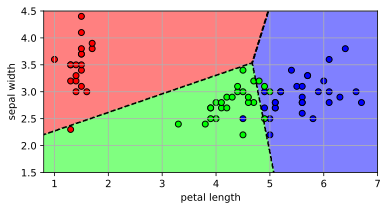

In [45]:
svm3fig

# Decision boundaries for each binary classifier

In [58]:
bfig = plt.figure(figsize=(8,5.5))
for i in range(3):
    plt.subplot(2,2,i+1)
    myclf = msvmcv.best_estimator_.estimators_[i]
    plot_svm(myclf, axbox, mycmap, showleg=False)
    plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
    plt.title('{} vs rest'.format(i+1))
plt.subplot(2,2,4)
plot_posterior3(msvmcv, axbox, mycmap, showscore=True)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.axis(); plt.axis(axbox);
plt.title("combined")
plt.grid(True)
plt.close()

[[-1.04615354  0.36923066]]
[[-0.14902716 -2.23820701]]
[[ 4.44425028 -1.33309667]]


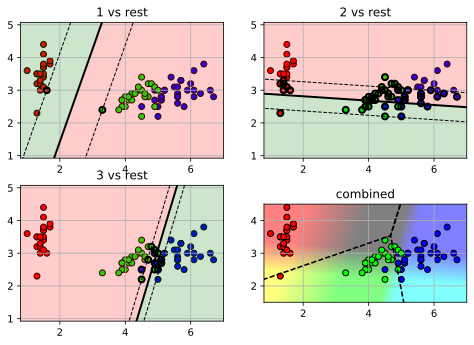

In [59]:
for bclf in msvmcv.best_estimator_.estimators_:
    print(bclf.coef_)
bfig

# SVM Summary
- **Classifier:**
  - linear function $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b$
  - given new sample $\mathbf{x}_*$, predict $y_* = \mathrm{sign}(f(\mathbf{x}_*))$.
- **Training:**
  - Maximize the margin of the training data.
    - i.e., maximize the separation between the points and the decision boundary.
  - Allow some training samples to violate the margin.
    - Use cross-validation to pick the hyperparameter $C$.

# Summary
- **Linear classifiers:**
  - separate the data using a linear surface (hyperplane).
  - $y = \mathrm{sign}(\mathbf{w}^T\mathbf{x} + b)$
- **Two formulations:**
  - logistic regression - maximize the probability of the data
  - support vector machine - maximize the margin of the hyperplane

In [48]:
z = linspace(-6,6,100)
logloss = log(1+exp(-z)) / log(2)
hingeloss = maximum(0, 1-z)
lossfig = plt.figure()

plt.plot([0,0], [0,9], 'k--')
plt.text(0,8.5, "incorrectly classified $\\Leftarrow$ ", ha='right', weight='bold')
plt.text(0,8.5, " $\Rightarrow$ correctly classified", ha='left', weight='bold')

plt.plot(z,hingeloss, 'b-', label='hinge (SVM)')
plt.plot(z,logloss, 'r-', label='logistic (LR)')
plt.grid(True)
plt.xlabel('$z_i$');
plt.ylabel('loss')
plt.legend(loc='right')
plt.title('loss functions')
plt.xlim(-6,6)
plt.close()

- **Loss functions**
  - SVM - ensure a margin of 1 between boundary and closest point
  - LR - push the classification boundary as far as possible from all points

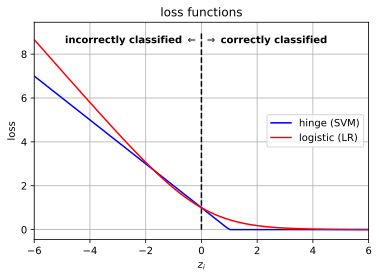

In [49]:
lossfig

- **Advantages:**
  - SVM works well on high-dimensional features ($d$ large), and has low generalization error.
  - LR has well-calibrated probabilities.
- **Disadvantages:**
  - decision surface can only be linear! 
    - Next lecture we will see how to deal with non-linear decision surfaces.